In [6]:
!pip install torch_geometric
!pip install torchviz

In [7]:
import numpy as np
import torch
import torch_geometric
import h5py
import matplotlib.pyplot as plt

from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from sklearn.neighbors import kneighbors_graph
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch_geometric.nn import global_mean_pool
from torch.nn import Linear

In [8]:
Data_Path = '/kaggle/input/paraquet-df/quark-gluon_data-set_n139306.hdf5'
Data_Size = 40000
k = 8

In [9]:
import h5py
import numpy as np
import torch
from torch_geometric.data import Data
from sklearn.neighbors import kneighbors_graph

def load_data(k=8, max_nodes=800, activation_threshold=1e-3):
    # Adding coordinates to the featues.
    data = h5py.File(Data_Path, "r")
    images = data['X_jets'][0:Data_Size]
    coords = np.indices((125, 125))
    coords = np.moveaxis(coords, 1, -1).T
    coords = np.expand_dims(coords, axis=0)
    coords = coords.astype(np.float32) / 125.
    coords = np.repeat(coords, Data_Size, axis=0)

    # Surpressing smaller activations
    images[images < activation_threshold] = 0.0
    images_with_coords = np.concatenate((images, coords), axis=-1)

    del coords
    del images
    del data

    data = images_with_coords.reshape((-1, images_with_coords.shape[1] * images_with_coords.shape[2], 5))
    non_black_pixels_mask = np.any(data[..., :3] != [0., 0., 0.], axis=-1)
    node_list = []
    for i, x in enumerate(data):
        node_list.append(x[non_black_pixels_mask[i]])
    """for i, x in enumerate(data):
        mask = np.any(x[..., :3] != [0., 0., 0.], axis=-1)
        filtered_nodes = x[mask]
        # canonical ordering of nodes.(sorted positions)
        sorted_nodes = filtered_nodes[np.lexsort((filtered_nodes[:, 4], filtered_nodes[:, 3]))]

        if sorted_nodes.shape[0] > max_nodes:
            sorted_nodes = sorted_nodes[:max_nodes]
        
        node_list.append(sorted_nodes)
    """
    dataset = []
    for i, nodes in enumerate(node_list):
        edges = kneighbors_graph(nodes[..., 3:], k, mode='connectivity', include_self=True)
        c = edges.tocoo()
        edge_list = torch.from_numpy(np.vstack((c.row, c.col))).type(torch.long)
        edge_weight = torch.from_numpy(c.data.reshape(-1, 1))
        data = Data(x=torch.from_numpy(nodes), edge_index=edge_list, edge_attr=edge_weight)
        dataset.append(data)
    
    return dataset


In [44]:
dataset = load_data()
train_loader = DataLoader(dataset[:36000], batch_size=64, shuffle=True)
test_loader = DataLoader(dataset[36000:36004], batch_size=1, shuffle=False)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from torchmetrics.image import StructuralSimilarityIndexMeasure

ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0)

def reconstruct_image(features):
    x_coords = (features[:, -2] * 125).cpu().numpy().astype(int)
    y_coords = (features[:, -1] * 125).cpu().numpy().astype(int)
    tracks_act = features[:, 0].cpu().numpy()
    ecal_act = features[:, 1].cpu().numpy()
    hcal_act = features[:, 2].cpu().numpy()

    img_tracks = np.zeros((125, 125))
    img_ecal = np.zeros((125, 125))
    img_hcal = np.zeros((125, 125))

    for i in range(len(x_coords)):
        if 0 <= x_coords[i] < 125 and 0 <= y_coords[i] < 125:
            img_tracks[y_coords[i], x_coords[i]] = tracks_act[i]
            img_ecal[y_coords[i], x_coords[i]] = ecal_act[i]
            img_hcal[y_coords[i], x_coords[i]] = hcal_act[i]

    # Stack the channels to get a 3-channel image
    image = np.stack([img_tracks, img_ecal, img_hcal], axis=0)
    return torch.tensor(image, dtype=torch.float32).unsqueeze(0) / np.max(image)
    
def calculate_ssim(data, x):
    original_image = reconstruct_image(data)
    reconstructed_image = reconstruct_image(x)

    # Ensure both images are in the correct format
    original_image = original_image.clamp(0, 1)
    reconstructed_image = reconstructed_image.clamp(0, 1)

    ssim_score = ssim_metric(reconstructed_image, original_image)
    return ssim_score.item()

In [13]:
def visualize(data):
    x = data[:,3]
    y = data[:,4]
    tracks_act = data[:,0]
    hcal_act = data[:,2]
    ecal_act = data[:,1]
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    axs[0].set_xlim(0, 1)  # Force x-axis to show 0-1 range
    axs[0].set_ylim(0, 1)
    # Plot tracks_act
    axs[0].scatter(x, y, c=tracks_act, s= torch.abs(tracks_act) * 500, cmap='inferno', alpha=0.5)
    axs[0].set_title('Tracks Activity')
    axs[0].set_xlabel('X')
    axs[0].set_ylabel('Y')

    axs[1].set_xlim(0, 1)  # Force x-axis to show 0-1 range
    axs[1].set_ylim(0, 1)
    # Plot ecal_act
    axs[1].scatter(x, y,  c=ecal_act, s= torch.abs(ecal_act) * 500, cmap='inferno', alpha=0.5)
    axs[1].set_title('Ecal Activity')
    axs[1].set_xlabel('X')
    axs[1].set_ylabel('Y')

    axs[2].set_xlim(0, 1)  # Force x-axis to show 0-1 range
    axs[2].set_ylim(0, 1)
    # Plot hcal_act
    axs[2].scatter(x, y, c=hcal_act, s= torch.abs(hcal_act) * 500, cmap='inferno', alpha=0.5)
    axs[2].set_title('Hcal Activity')
    axs[2].set_xlabel('X')
    axs[2].set_ylabel('Y')


    plt.tight_layout()
    plt.show()

In [53]:
from torch_geometric.nn import SAGEConv, GATConv

# Node level latent Graph Auto Encoder
class GAE(torch.nn.Module):
  def __init__(self, input_embed_dim : int, latent_dim = None):
    super(GAE, self).__init__()
    
    self.node_dim = input_embed_dim
    if latent_dim is None:
      self.latent_dim = self.node_dim
    else:
      self.latent_dim = latent_dim
    
    self.Conv1 = GATConv(self.node_dim, self.latent_dim, heads=1, concat=False)
    self.Conv2 = GATConv(self.latent_dim, 2*self.latent_dim, heads=1, concat=False)
    self.Conv3 = GATConv(2*self.latent_dim, 4*self.latent_dim, heads=1, concat=False)
    self.Conv4 = GATConv(4*self.latent_dim, 8*self.latent_dim, heads=1, concat=False)
    self.ReConv1 = GATConv(8*self.latent_dim, 4*self.latent_dim)
    self.ReConv2 = GATConv(4*self.latent_dim, 2*self.latent_dim)
    self.ReConv3 = GATConv(2*self.latent_dim, self.latent_dim)
    self.ReConv4 = GATConv(self.latent_dim, self.node_dim)
    self.p5 = nn.Dropout(p=0.5)
    self.p3 = nn.Dropout(p=0.3)
    self.p1 = nn.Dropout(p=0.1)
    

  def forward(self, x, edge_index):
    
    # Encoder.
    x = F.relu(self.Conv1(x, edge_index))
    x = F.relu(self.Conv2(x, edge_index))
    x = F.relu(self.Conv3(x, edge_index))
    x = F.relu(self.Conv4(x, edge_index))

    # Decoder  
    x = F.relu(self.ReConv1(x, edge_index))
    #x = self.p1(x)
    x = F.relu(self.ReConv2(x, edge_index))
    #x = self.p1(x)
    x = F.relu(self.ReConv3(x, edge_index))
    #x = self.p1(x)
    x = self.ReConv4(x, edge_index)
    
    
    return x

In [54]:
from tqdm import tqdm

def train(num_epochs=50):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False) as t:
            for batch in t:
                batch = batch.to(device)
                reconstructed_x = model(batch.x, batch.edge_index)
                loss = F.mse_loss(reconstructed_x, batch.x)  # Standard MSE loss for feature reconstruction
                
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                total_loss += loss.item()
                t.set_postfix(loss=loss.item())
        
        avg_loss = total_loss / len(train_loader)

        print(f"Epoch {epoch+1}, Train Loss: {avg_loss:.4f}")

        inference(model,test_loader,device,vis=((epoch + 1) % 10 == 0))

In [55]:
def inference(model, data_loader, device, vis=False):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        with tqdm(data_loader, desc="Inference", leave=False) as t:
            for data in t:
                data = data.to(device)
                out = model(data.x, data.edge_index)
                total_loss += F.mse_loss(out, data.x).item()
                
                x, mask = torch_geometric.utils.to_dense_batch(data.x, data.batch, fill_value=0)
                if vis:
                    visualize(x[0].cpu())
                    visualize(out.detach().cpu())
                    ssim_score = calculate_ssim(data.x, out)
                    print(f"SSIM Score: {ssim_score}")

        avg_loss = total_loss / len(data_loader) if len(data_loader) > 0 else 0
        return avg_loss
                

Epoch 1, Train Loss: 0.0148


Epoch 2, Train Loss: 0.0020


Epoch 3, Train Loss: 0.0018


Epoch 4, Train Loss: 0.0018


Epoch 5, Train Loss: 0.0017


Epoch 6, Train Loss: 0.0017


Epoch 7, Train Loss: 0.0017


Epoch 8, Train Loss: 0.0017


Epoch 9, Train Loss: 0.0017


Epoch 10, Train Loss: 0.0017


Inference:   0%|          | 0/4 [00:00<?, ?it/s]

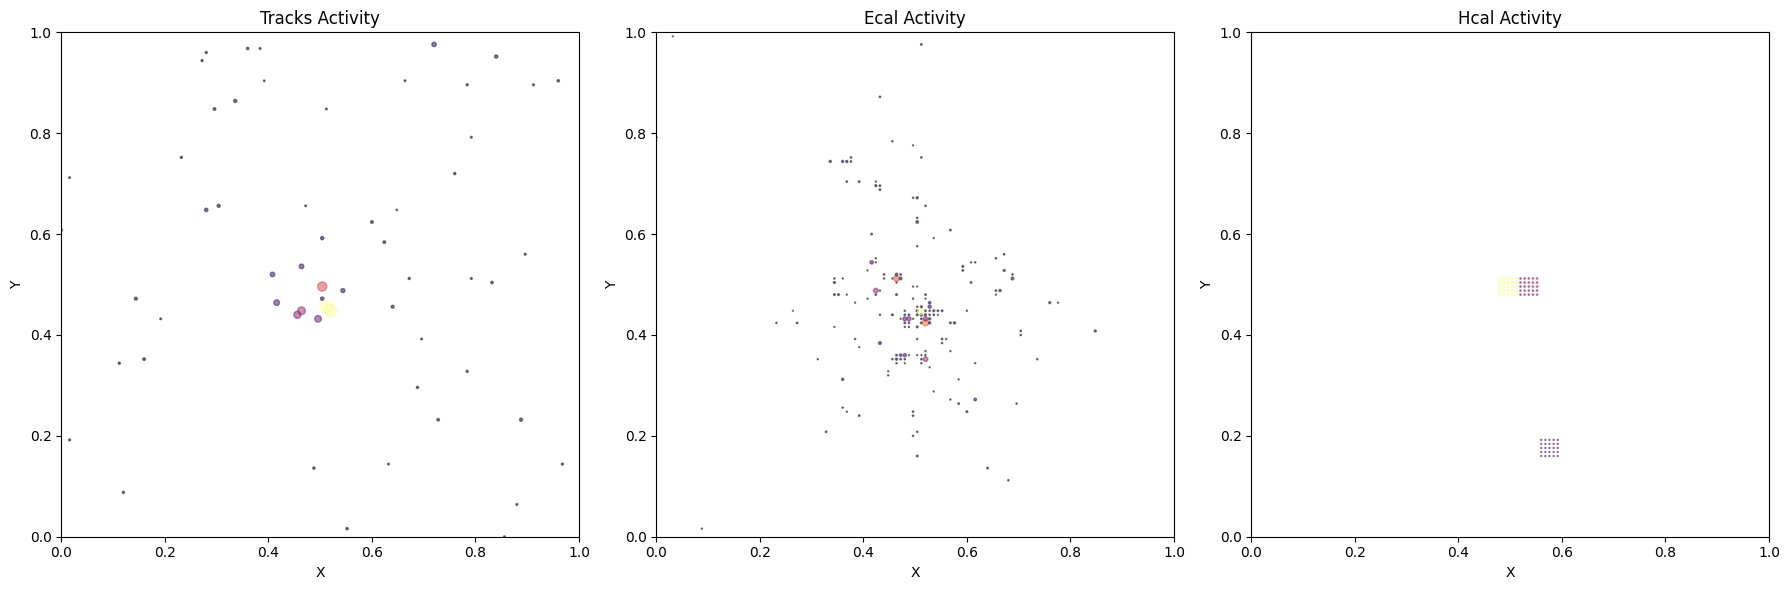

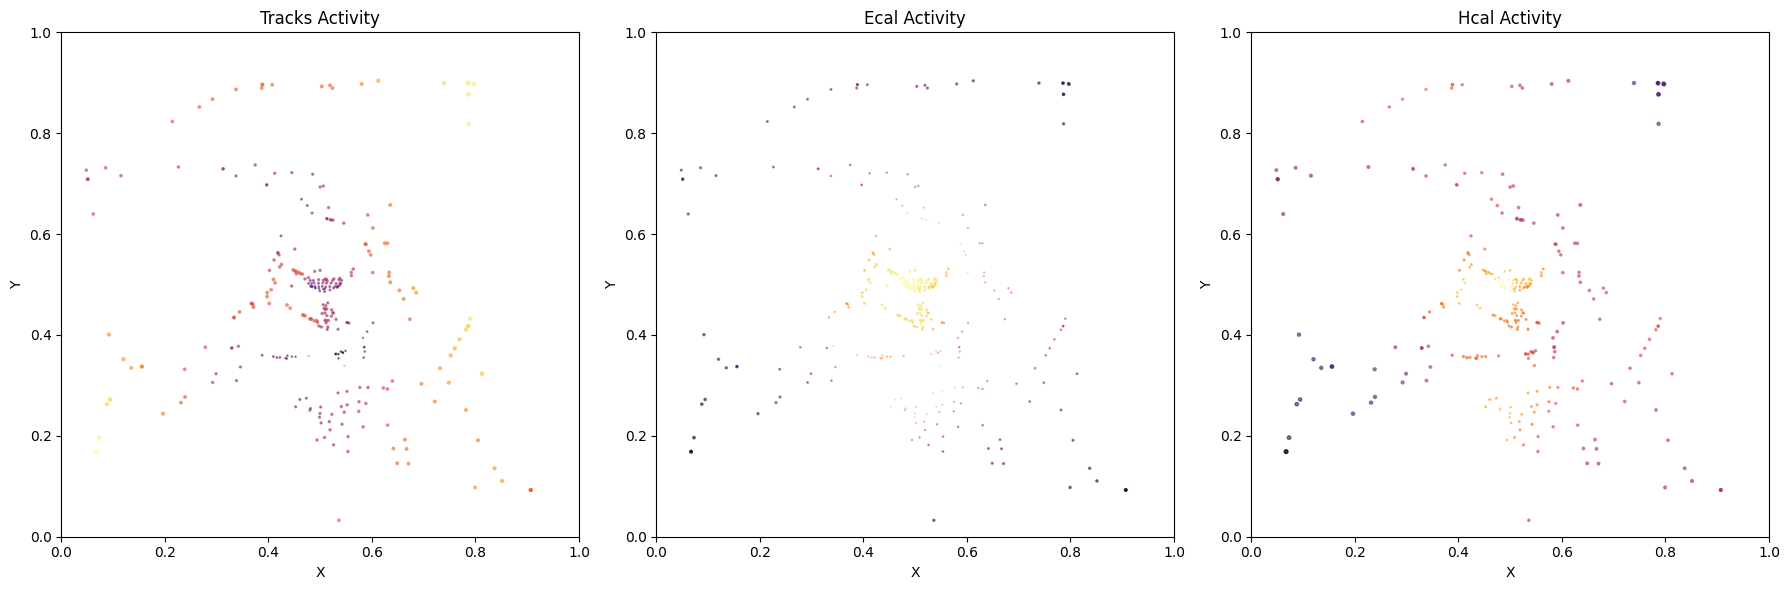

Inference:  25%|██▌       | 1/4 [00:01<00:03,  1.15s/it]

SSIM Score: 0.8978720903396606


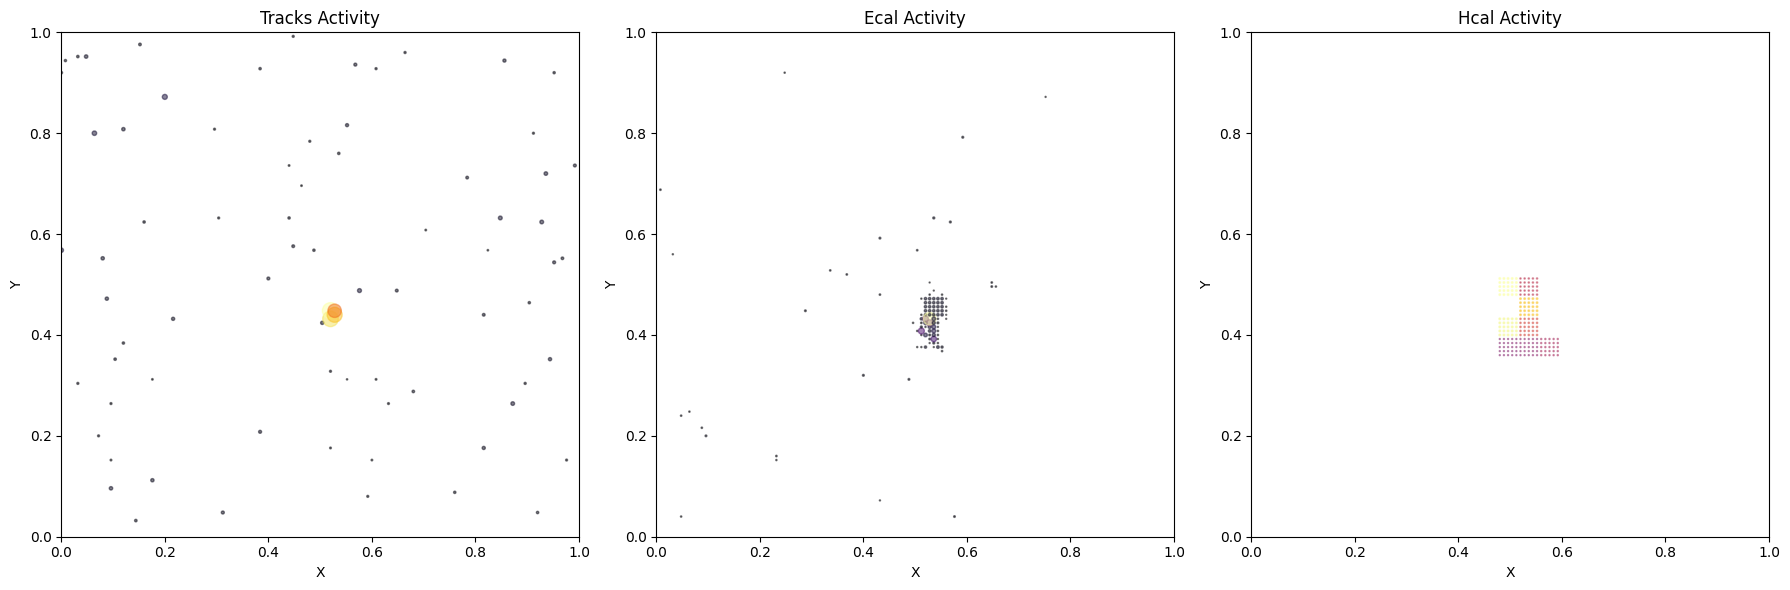

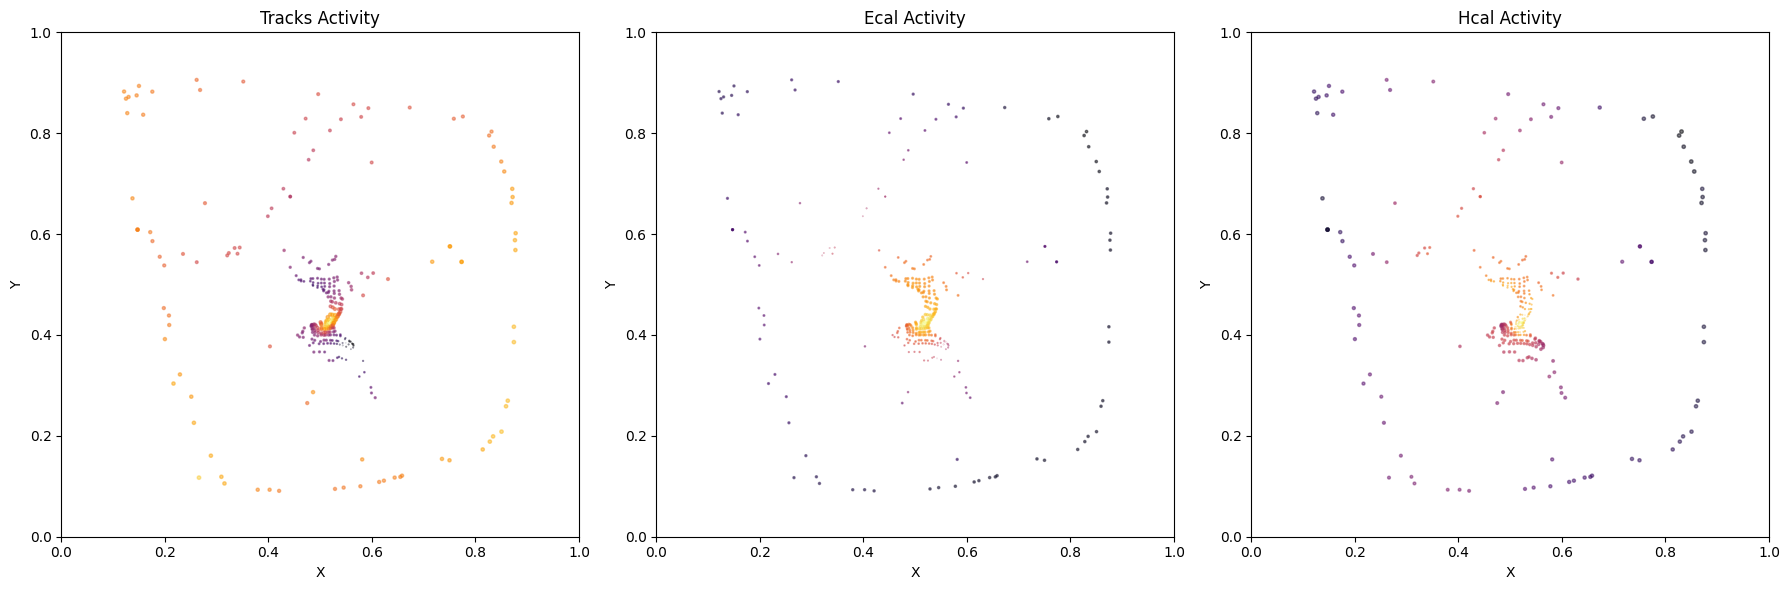

Inference:  50%|█████     | 2/4 [00:02<00:02,  1.14s/it]

SSIM Score: 0.9074076414108276


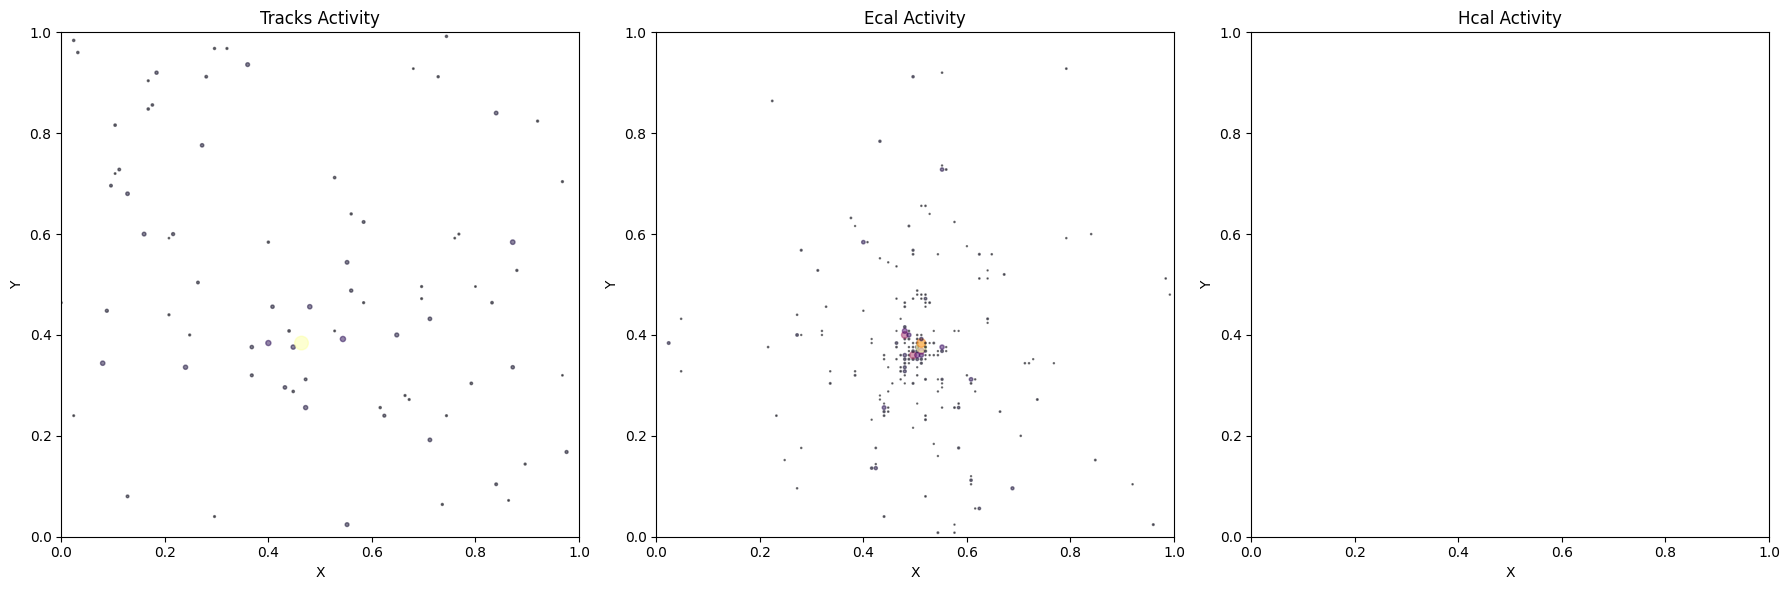

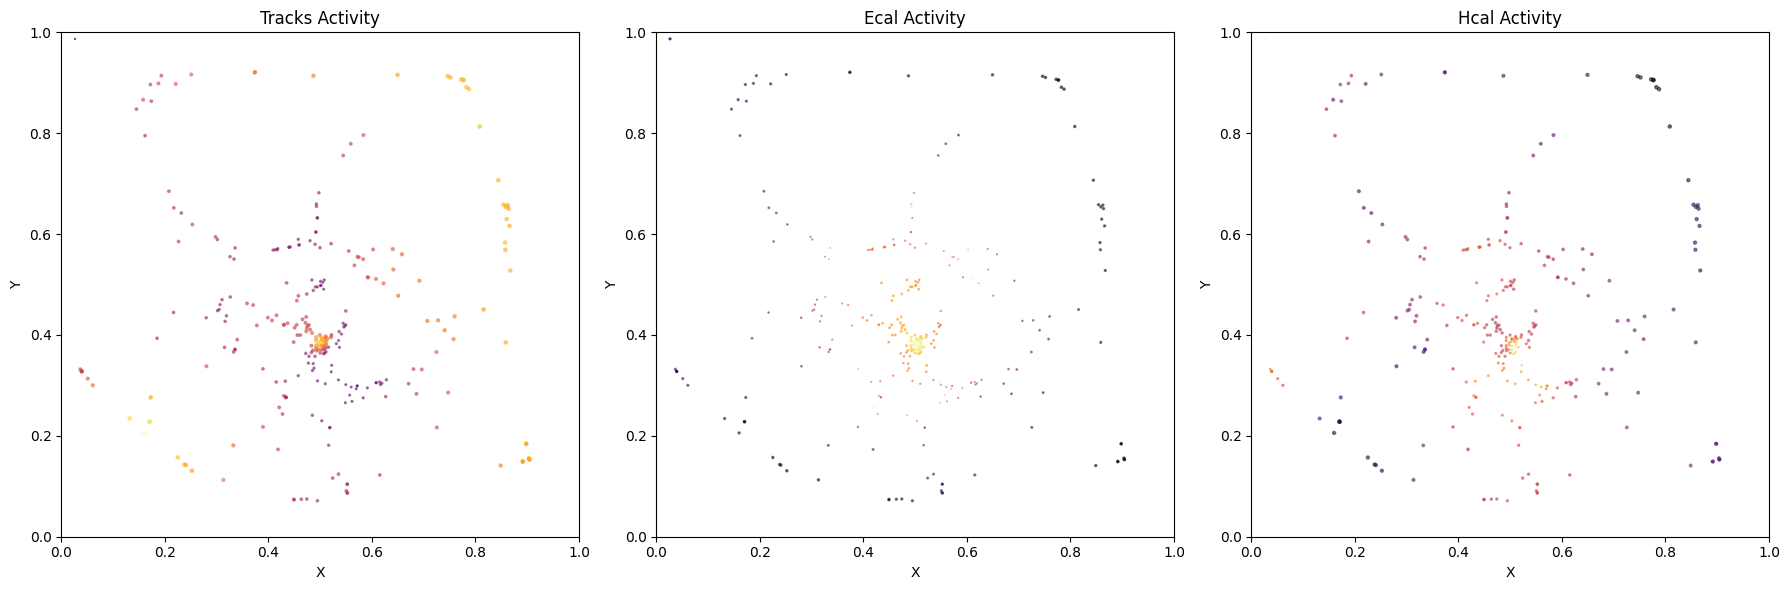

Inference:  75%|███████▌  | 3/4 [00:03<00:01,  1.15s/it]

SSIM Score: 0.892655611038208


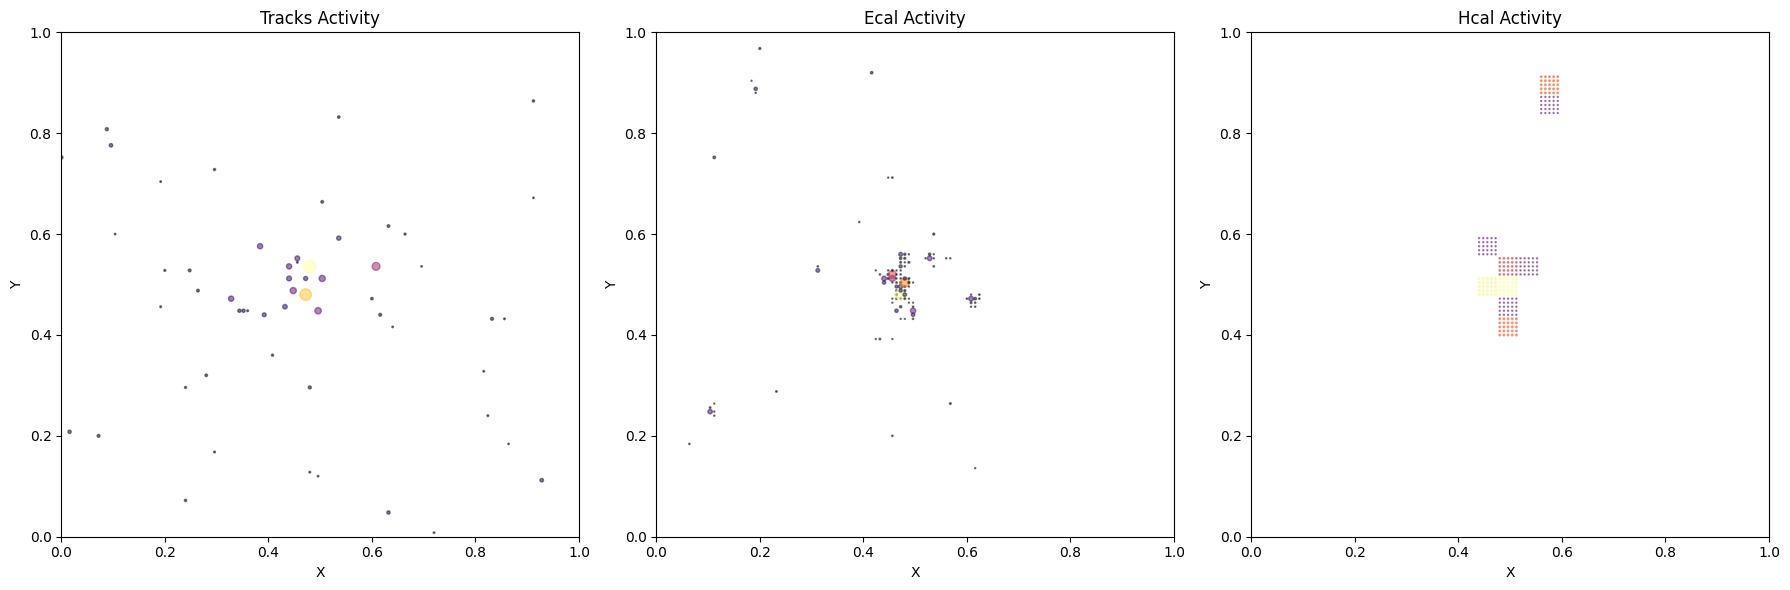

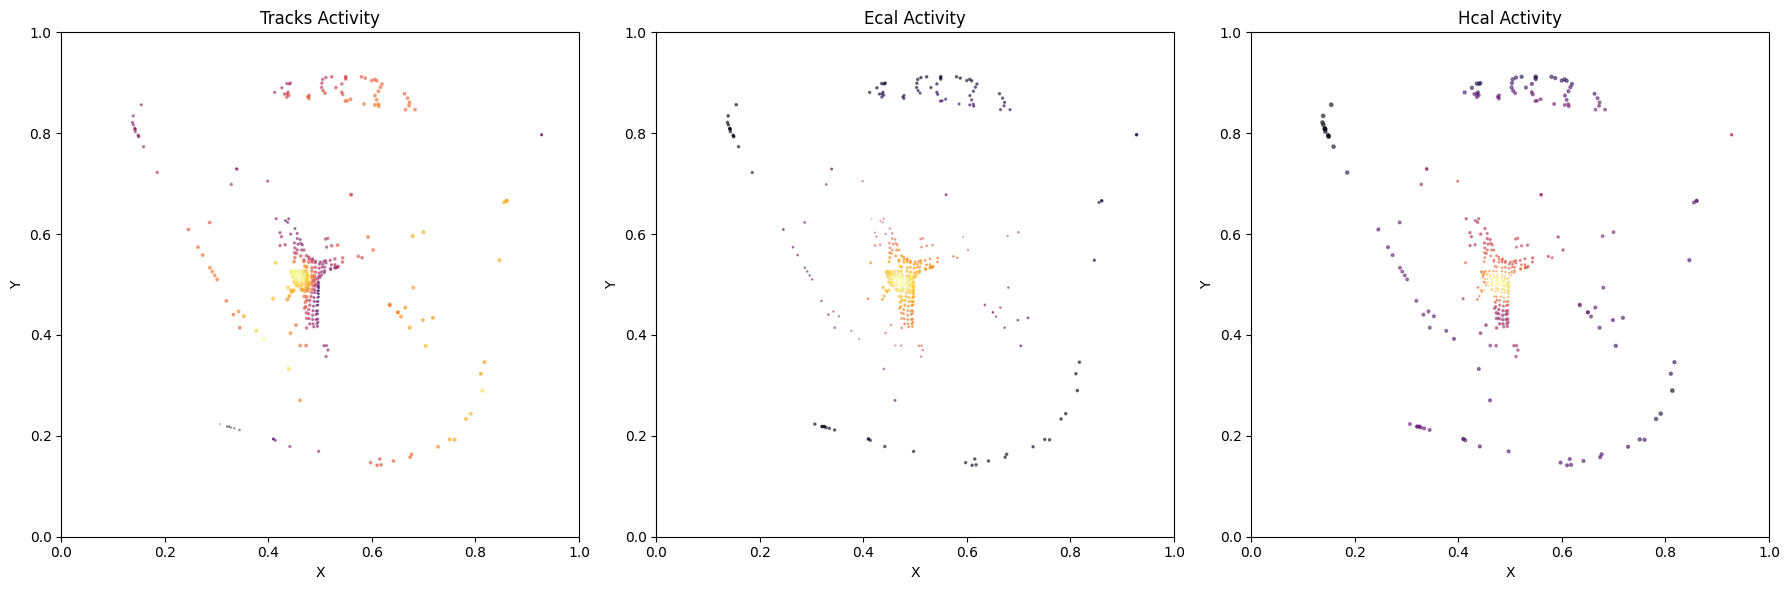

SSIM Score: 0.9159401655197144


Epoch 11, Train Loss: 0.0017


Epoch 12, Train Loss: 0.0017


Epoch 13, Train Loss: 0.0017


Epoch 14, Train Loss: 0.0016


Epoch 15, Train Loss: 0.0016


Epoch 16, Train Loss: 0.0016


Epoch 17, Train Loss: 0.0016


Epoch 18, Train Loss: 0.0016


Epoch 19, Train Loss: 0.0016


Epoch 20, Train Loss: 0.0016


Inference:   0%|          | 0/4 [00:00<?, ?it/s]

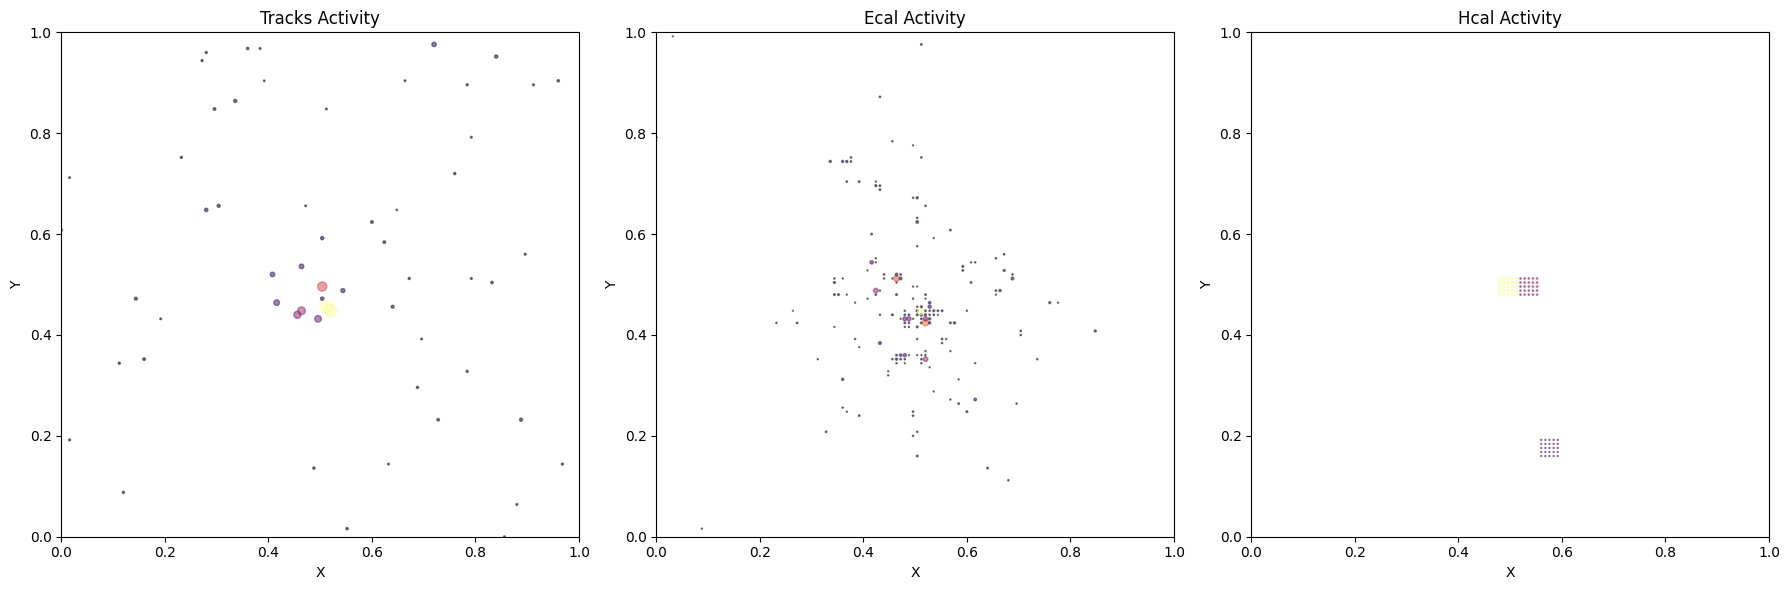

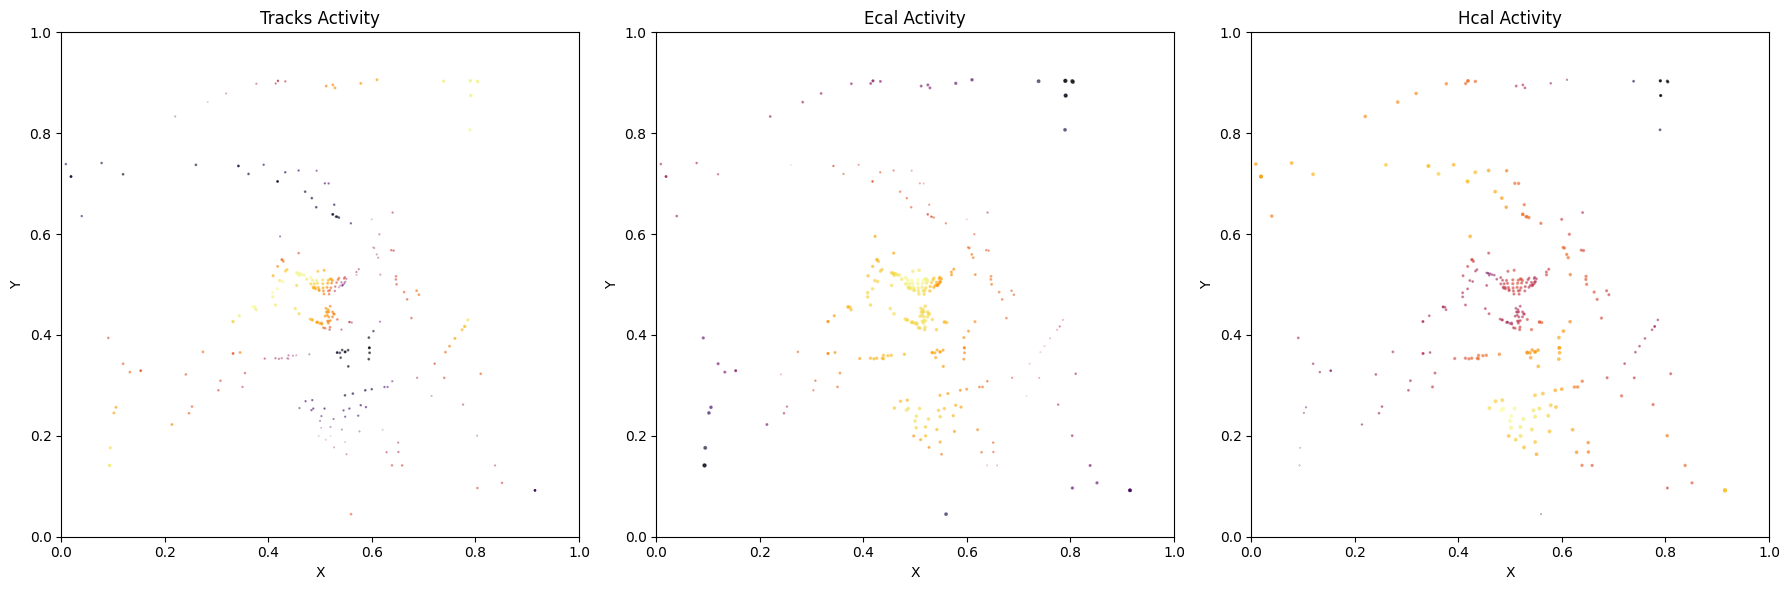

Inference:  25%|██▌       | 1/4 [00:01<00:04,  1.55s/it]

SSIM Score: 0.845172643661499


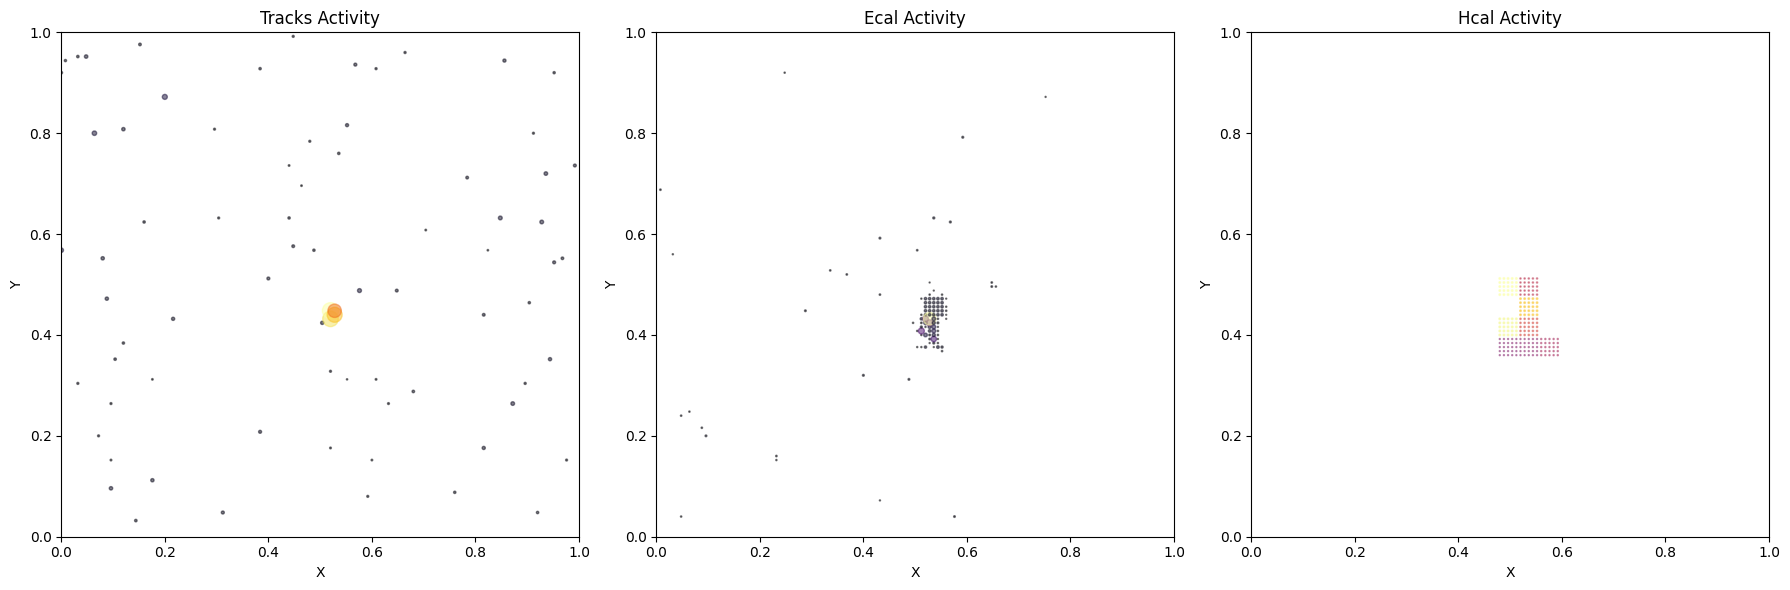

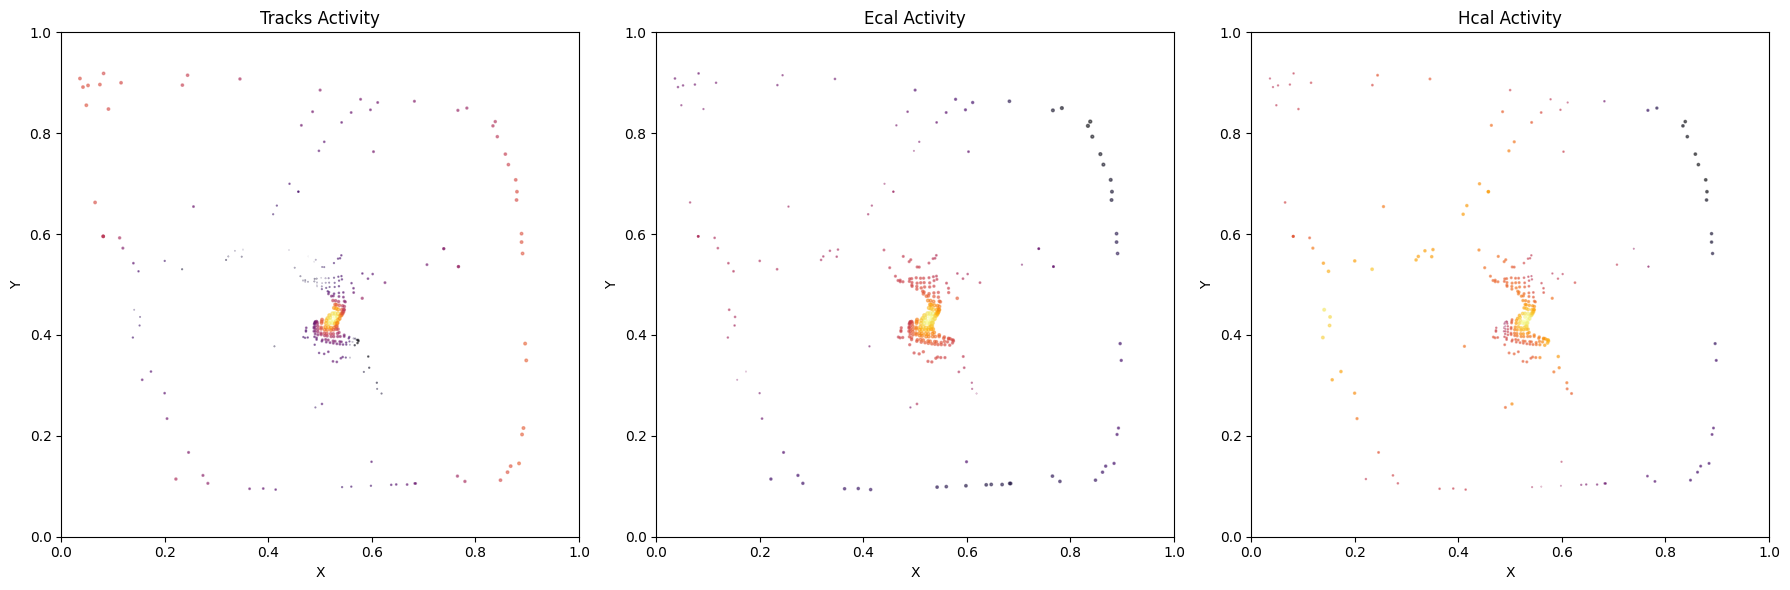

Inference:  50%|█████     | 2/4 [00:02<00:02,  1.31s/it]

SSIM Score: 0.9013151526451111


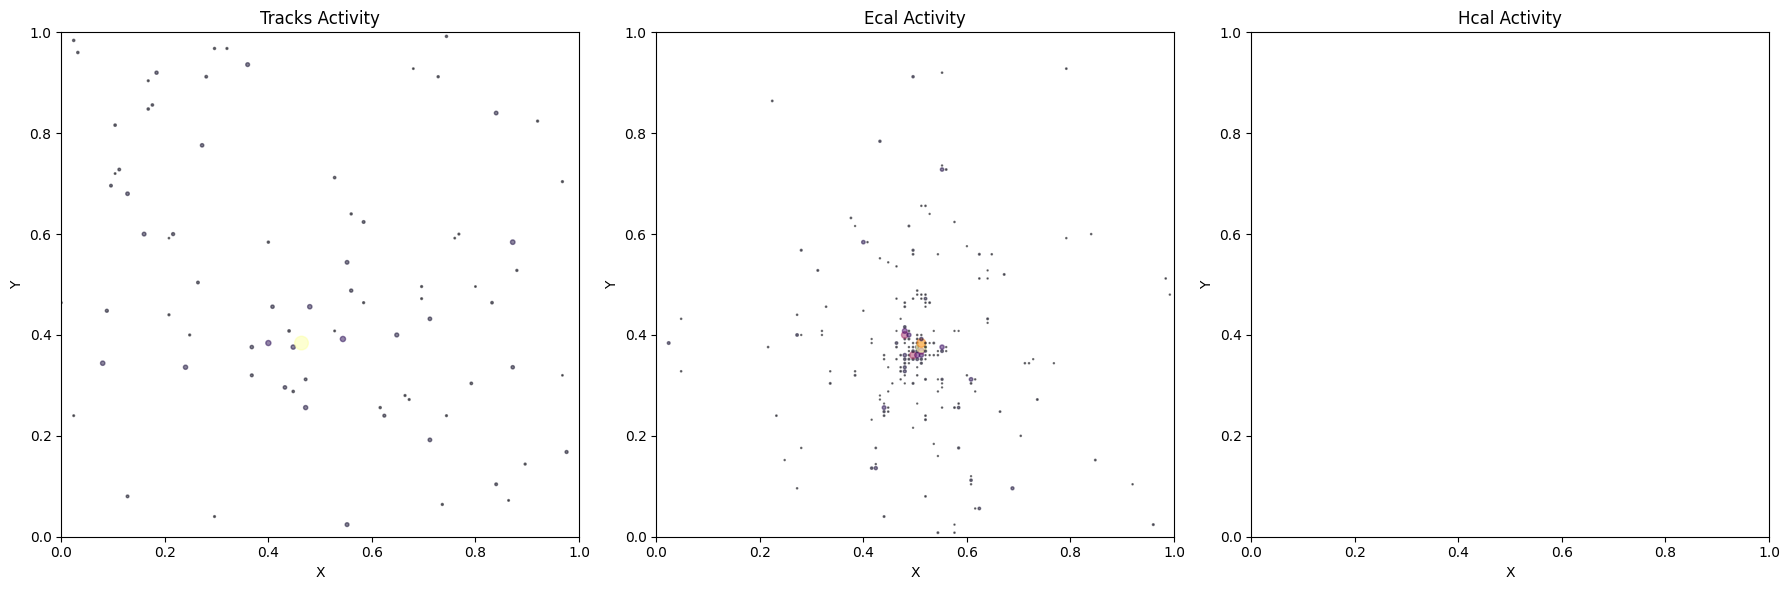

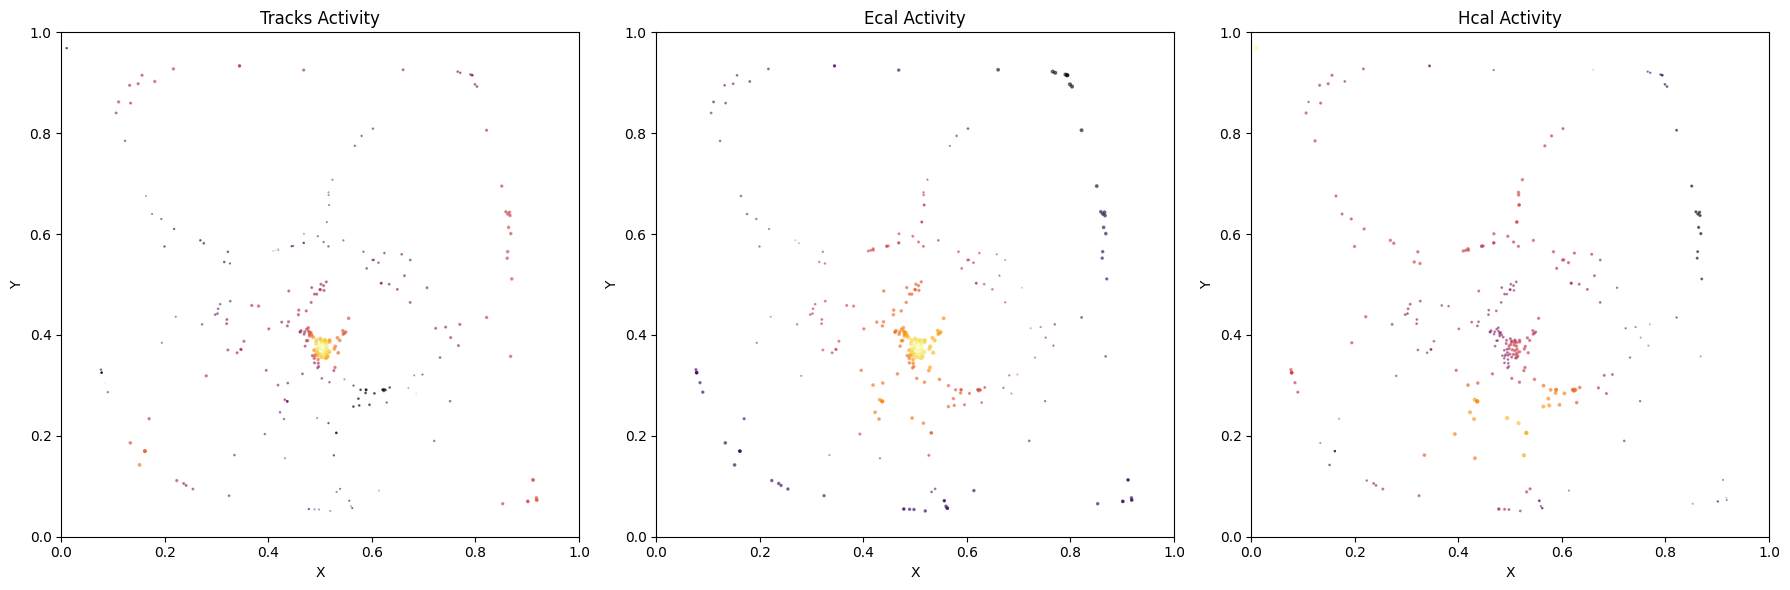

Inference:  75%|███████▌  | 3/4 [00:03<00:01,  1.23s/it]

SSIM Score: 0.8593122363090515


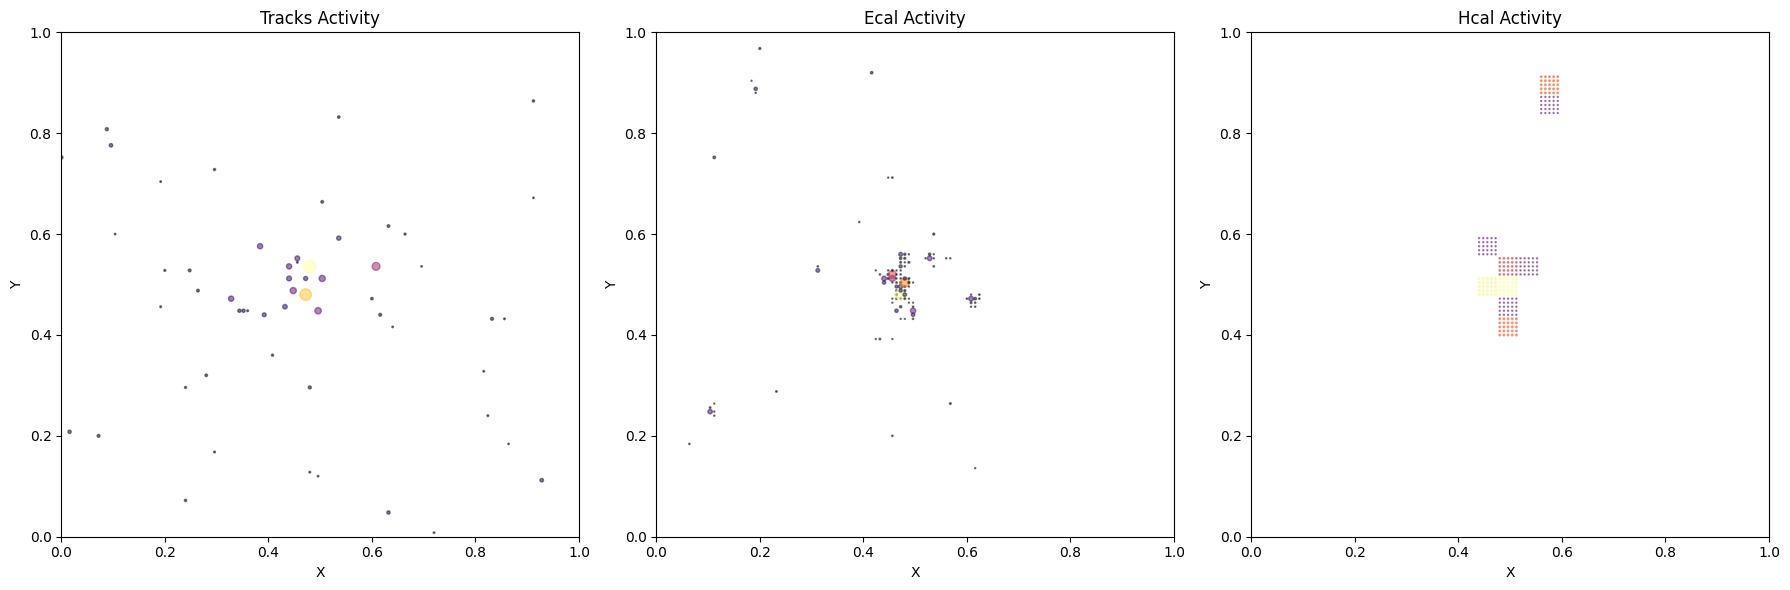

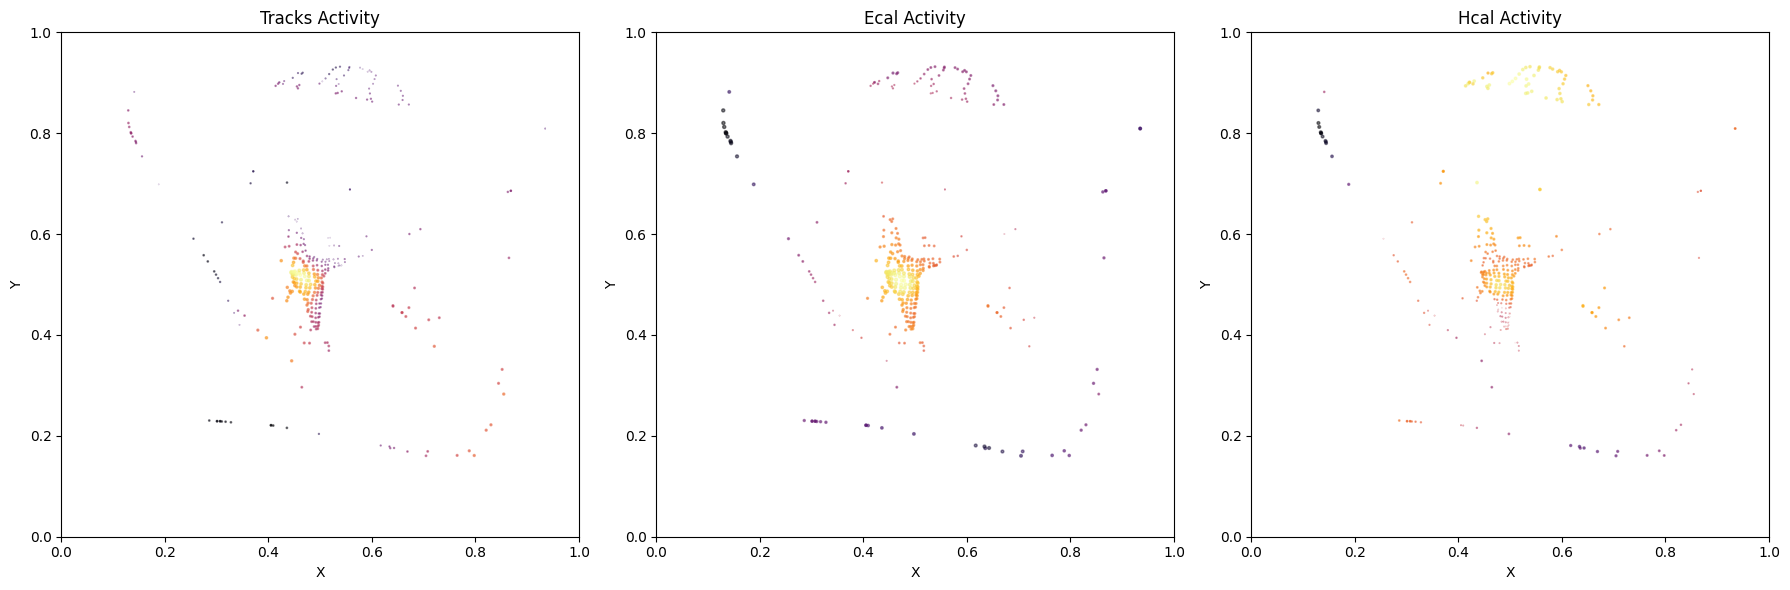

SSIM Score: 0.915593147277832


Epoch 21, Train Loss: 0.0016


Epoch 22, Train Loss: 0.0015


Epoch 23, Train Loss: 0.0015


Epoch 24, Train Loss: 0.0015


Epoch 25, Train Loss: 0.0015


Epoch 26, Train Loss: 0.0015


Epoch 27, Train Loss: 0.0015


Epoch 28, Train Loss: 0.0015


Epoch 29, Train Loss: 0.0015


Epoch 30, Train Loss: 0.0015


Inference:   0%|          | 0/4 [00:00<?, ?it/s]

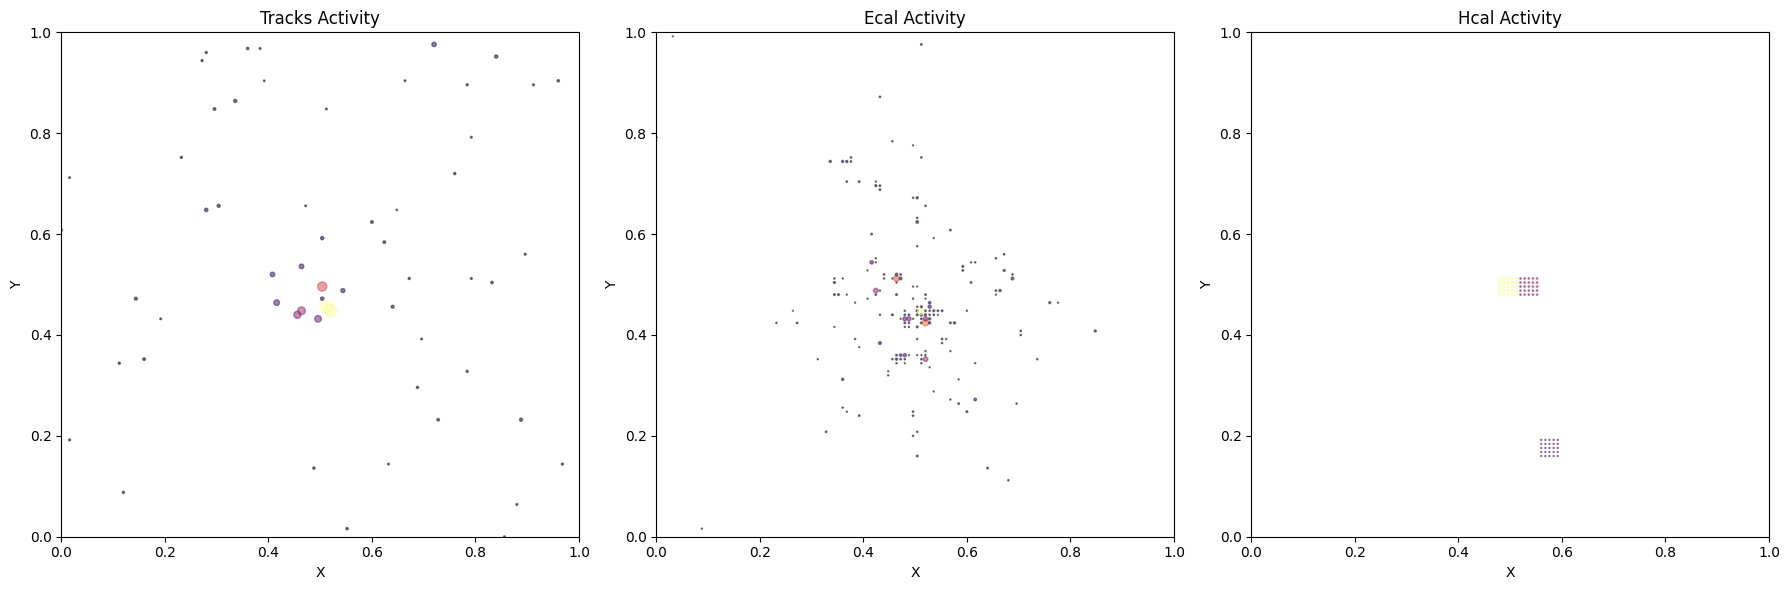

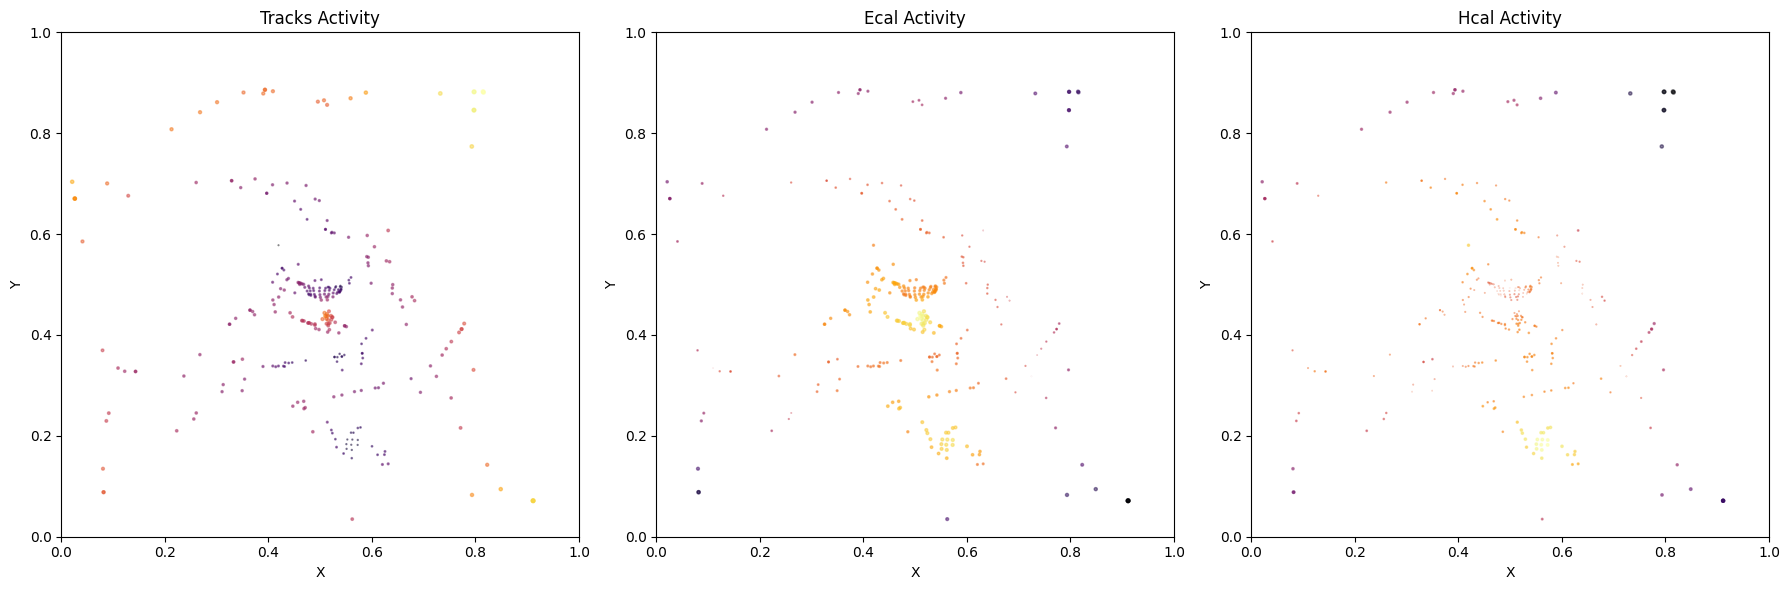

Inference:  25%|██▌       | 1/4 [00:01<00:03,  1.16s/it]

SSIM Score: 0.8597720861434937


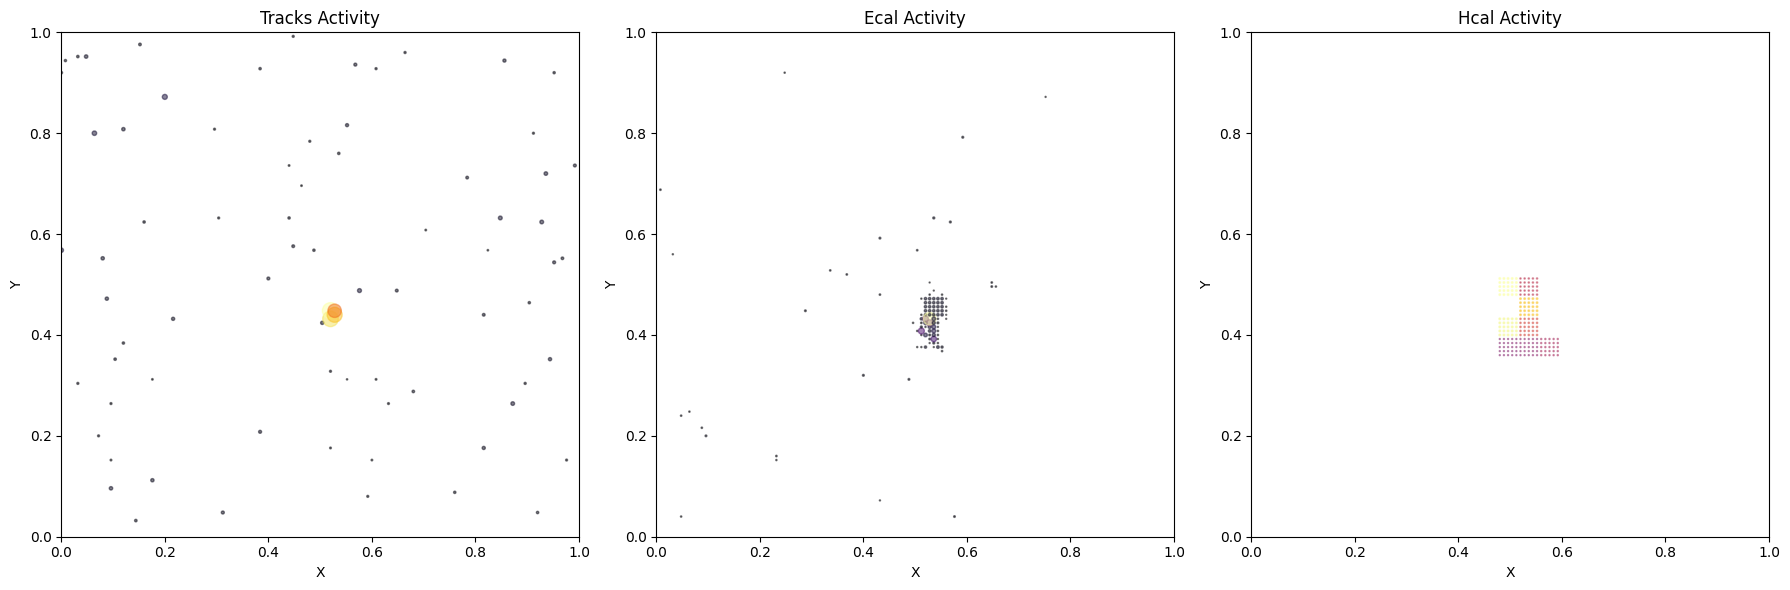

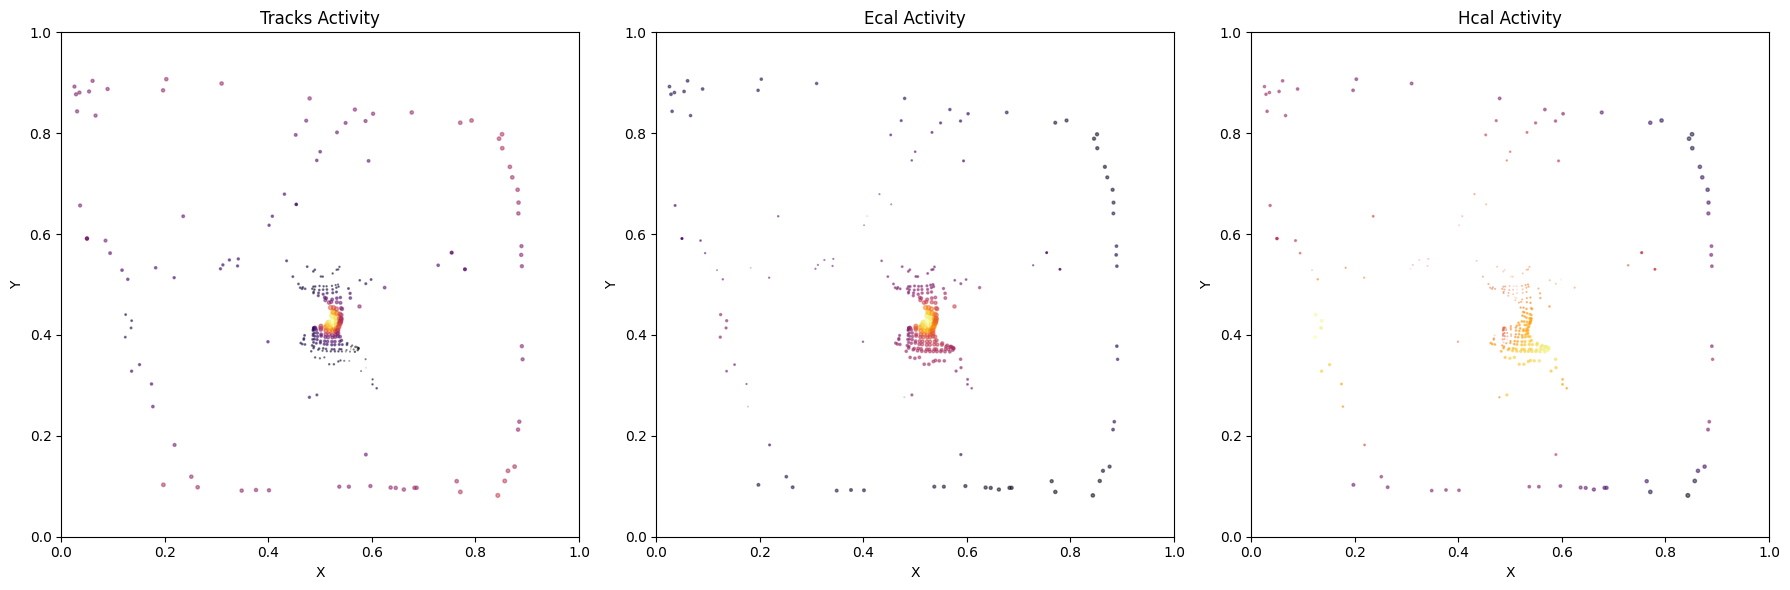

Inference:  50%|█████     | 2/4 [00:02<00:02,  1.15s/it]

SSIM Score: 0.9249793291091919


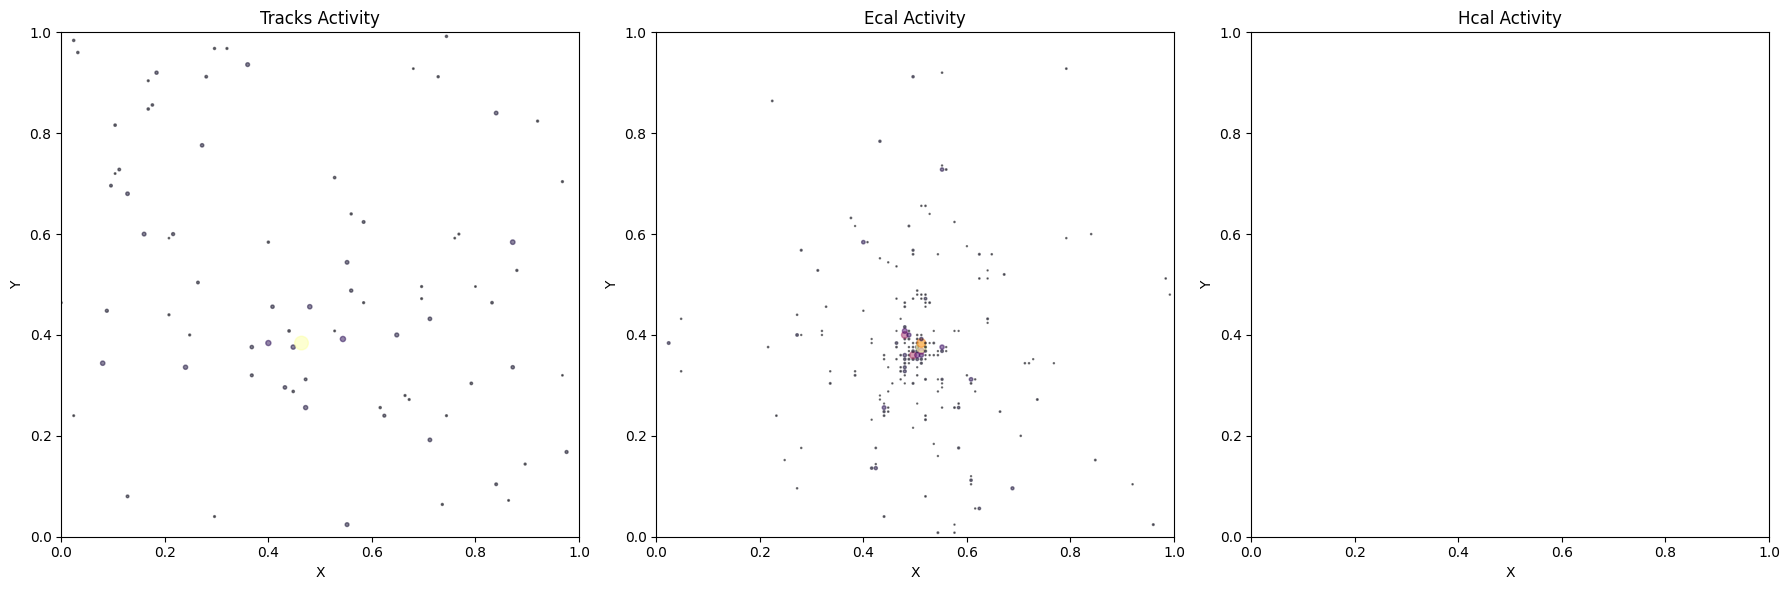

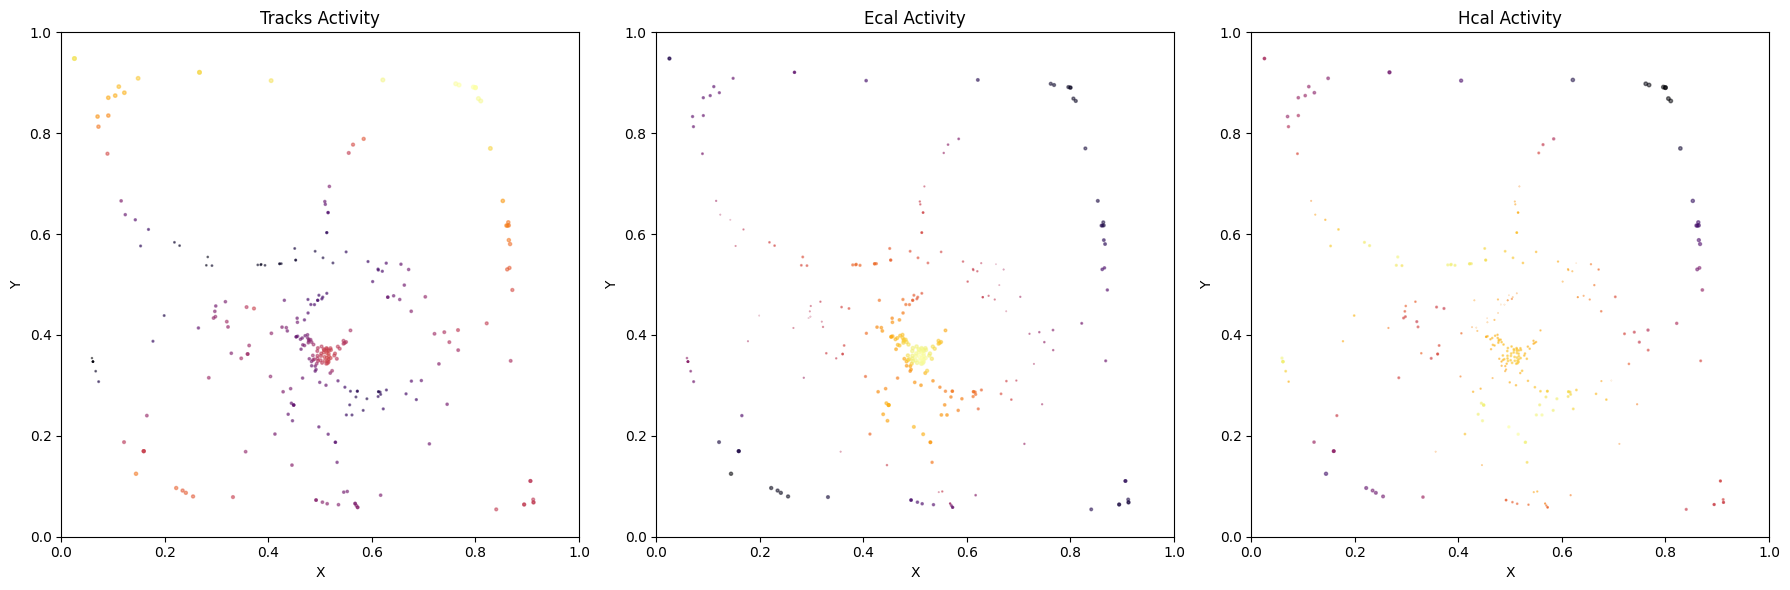

Inference:  75%|███████▌  | 3/4 [00:03<00:01,  1.14s/it]

SSIM Score: 0.8609766960144043


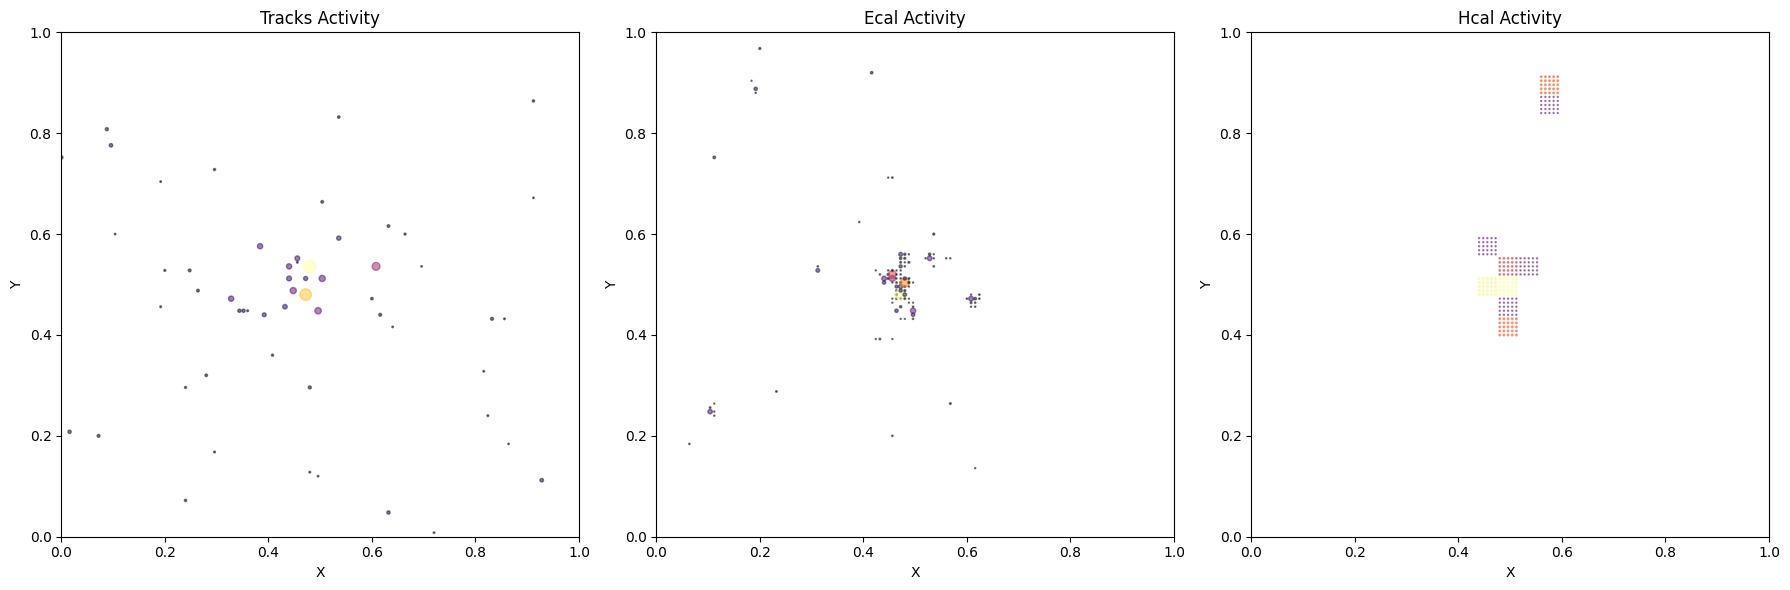

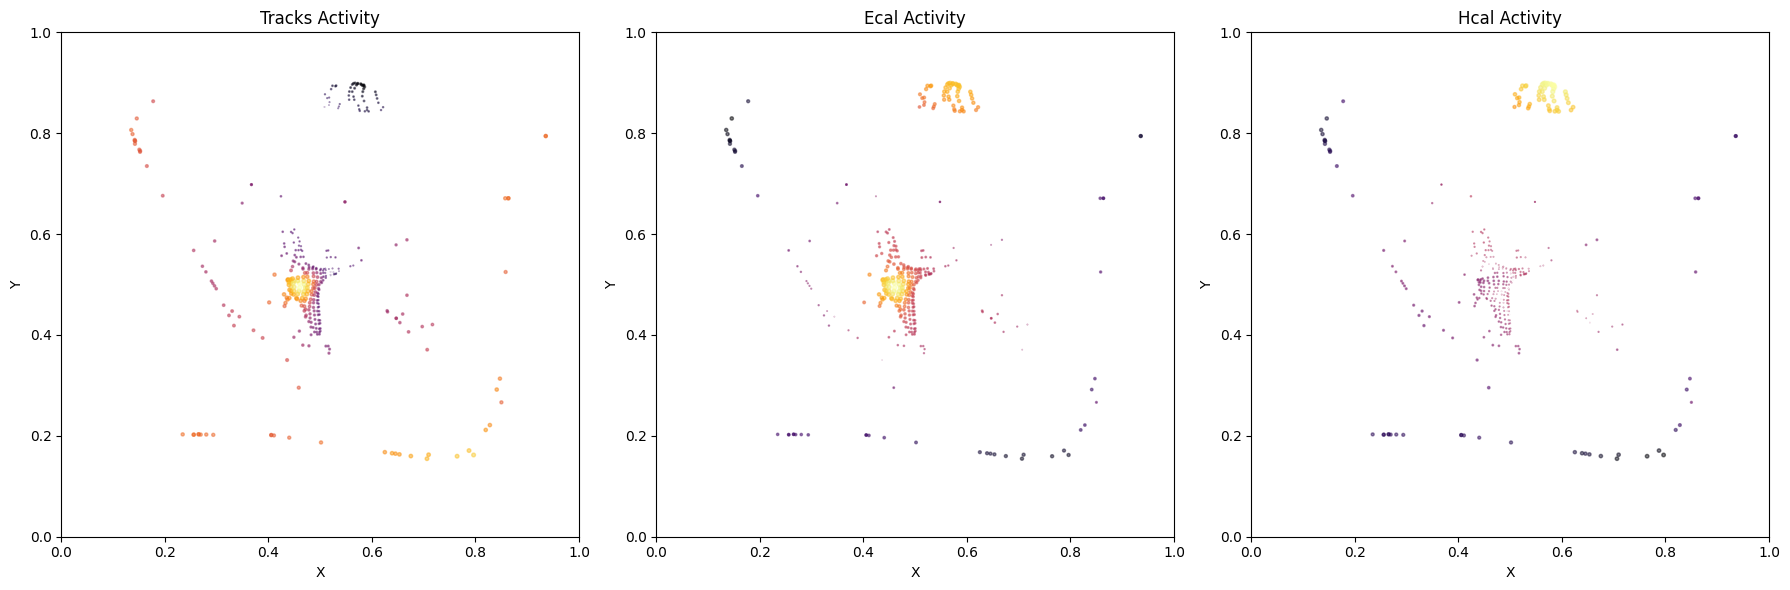

SSIM Score: 0.9211648106575012


In [56]:
model = GAE(5, 8)
#model = nn.DataParallel(model)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss = train(30)